# Opioid Addiction Project
Python Notebook 1 of x

This notebook is just to initially explore the data.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE #conda install -c conda-forge imbalanced-learn
from sklearn.externals import joblib  #Used to save (pickle) models
#from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import xgboost #conda install py-xgboost
import shap #conda install -c conda-forge shap
shap.initjs()  #Javascript for Shapley Values

#Set initial parameter(s)
pd.set_option('display.max_rows', 200)
pd.options.display.max_columns = 20
dataDir = './data/'

print(pd.__version__)

0.24.1


# 1. Load Data

In [2]:
#Load Data
dfNSDUHRaw = pd.read_csv(dataDir+'NSDUH_2017_Tab.tsv', sep='\t', low_memory=False)
#low_memory=False prevents an error

Note, I checked this against the .Rdata file and they appear to be the same.  `NA` values in R equate to `NaN` values here.

In [3]:
#Quick inspection
#dfRaw.head(20)

In [4]:
#dfNSDUHRaw.dtypes

In [5]:
#Write raw data to pkl file
#dfNSDUHRaw.to_pickle(dataDir + 'dfNSDUHRaw.pkl.zip', compression='zip')
'''This step is complete and there's no need to keep rewriting this file,
hence it's commented out
'''
;

''

# 2. Preprocessing

## 2.1 Remove Non Pain Reliever Users From the Data

This section will remove non-opioid users.

A reasonable approximation for additiction is misues, and a good candidate field for misuse is PNRNMREC: MOST RECENT PAIN RELIEVER MISUSE. It contains the following possible values:
* 1 = Within the past 30 days
* 2 = More than 30 days ago but within the past 12 mos
* 3 = More than 12 months ago
* 8 = Misused at some point in past 12 mos LOG ASSN
* 9 = Misused at some point in lifetime LOG ASSN
* 11 = Used in the past 30 days LOGICALLY ASSIGNED
* 83 = DID NOT MISUSE PST 12 MOS (LIFETIME UNK) Log assn
* 91 = NEVER USED/MISUSED PAIN RELIEVERS
* 98 = BLANK (NO ANSWER)

And here's a corresponding question that answers if patients have used any pain relievers in the past 12 months:
PNRANYREC MOST RECENT ANY PAIN RELIEVER USE.  It comes from the pain reliever screener portion of the survey.
* 1 = Within the past 12 months
* 2 = More than 12 months ago
* 9 = Used at some point in the lifetime LOG ASSN
* 83 = DID NOT USE PST 12 MOS (LIFETIME UNK) Log assn
* 91 = NEVER USED PAIN RELIEVERS
* 98 = BLANK (NO ANSWER)

Let's first get counts of each variable.

In [6]:
#Breakdown of PNRNMREC (misuse)
dfNSDUHRaw.groupby(['PNRNMREC'])['QUESTID2'].count()

PNRNMREC
1       777
2      1906
3      3160
8        20
9        37
11        1
83      485
91    49676
98      214
Name: QUESTID2, dtype: int64

In [7]:
#Breakdown of PNRANYREC (any use)
dfNSDUHRaw.groupby(['PNRANYREC'])['QUESTID2'].count()

PNRANYREC
1     16768
2     13180
9       153
83      343
91    25647
98      185
Name: QUESTID2, dtype: int64

Combining the data from PNRNMREC and PNRANYREC, we can filter the data for patients who have used prescription painkillers in the past 12 months (PNRANYREC==1).

In [8]:
dfUsePainMeds = dfNSDUHRaw[dfNSDUHRaw.PNRANYREC==1]
dfUsePainMeds

,QUESTID2,FILEDATE,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,POVERTY3,TOOLONG,TROUBUND,PDEN10,COUTYP4,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP
19,11577143,10/09/2018,2,4,4,991,9991,91,91,91,...,3.0,2,2,1,1,2,2,54.413648,40017,1
20,34608143,10/09/2018,1,99,99,12,9999,99,1,30,...,2.0,2,2,2,2,2,2,3481.596088,40013,2
21,33708143,10/09/2018,1,99,99,17,9999,99,4,93,...,2.0,2,2,2,2,2,2,1022.448042,40042,2
23,58638143,10/09/2018,2,99,99,991,9991,91,91,91,...,3.0,2,2,1,1,2,2,628.886384,40016,2
33,25359143,10/09/2018,2,99,99,991,9991,91,91,91,...,2.0,2,2,2,2,2,2,839.107735,40039,1
34,17779143,10/09/2018,1,99,99,18,9999,99,2,93,...,3.0,2,2,2,2,2,2,1400.781545,40017,2
36,45789143,10/09/2018,1,99,99,18,9999,99,4,93,...,2.0,1,1,2,3,2,2,1144.049469,40044,1
46,46911143,10/09/2018,2,99,99,991,9991,91,91,91,...,1.0,2,2,2,2,2,2,3090.284207,40006,2
50,67571143,10/09/2018,2,99,99,991,9991,91,91,91,...,3.0,2,2,2,2,2,2,4215.062783,40040,2
52,76622143,10/09/2018,2,4,4,991,9991,91,91,91,...,3.0,2,2,1,1,2,2,4121.742730,40043,1


So now we have a table of people who have used painkillers in the past 12 months.

## 2.2 Set Dependent Variable

Here we'll name our dependent variable MISUSE and set it = 1 if PNRNMREC %in% {1, 2, or 8}, otherwise = 0

In [9]:
#Set MISUSE variable
misuseCodes = [1, 2, 8]
dfUsePainMeds['MISUSE'] = dfUsePainMeds.apply(lambda row:
                                              1 if row.PNRNMREC in misuseCodes else 0,
                                              axis=1)

dfUsePainMeds

C:\Users\camke\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,QUESTID2,FILEDATE,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,TOOLONG,TROUBUND,PDEN10,COUTYP4,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,MISUSE
19,11577143,10/09/2018,2,4,4,991,9991,91,91,91,...,2,2,1,1,2,2,54.413648,40017,1,0
20,34608143,10/09/2018,1,99,99,12,9999,99,1,30,...,2,2,2,2,2,2,3481.596088,40013,2,0
21,33708143,10/09/2018,1,99,99,17,9999,99,4,93,...,2,2,2,2,2,2,1022.448042,40042,2,0
23,58638143,10/09/2018,2,99,99,991,9991,91,91,91,...,2,2,1,1,2,2,628.886384,40016,2,0
33,25359143,10/09/2018,2,99,99,991,9991,91,91,91,...,2,2,2,2,2,2,839.107735,40039,1,0
34,17779143,10/09/2018,1,99,99,18,9999,99,2,93,...,2,2,2,2,2,2,1400.781545,40017,2,1
36,45789143,10/09/2018,1,99,99,18,9999,99,4,93,...,1,1,2,3,2,2,1144.049469,40044,1,0
46,46911143,10/09/2018,2,99,99,991,9991,91,91,91,...,2,2,2,2,2,2,3090.284207,40006,2,1
50,67571143,10/09/2018,2,99,99,991,9991,91,91,91,...,2,2,2,2,2,2,4215.062783,40040,2,0
52,76622143,10/09/2018,2,4,4,991,9991,91,91,91,...,2,2,1,1,2,2,4121.742730,40043,1,0


In [10]:
#Determine classification imbalance
print('COUNT of MISUSE')
print(dfUsePainMeds.groupby(['MISUSE'])['MISUSE'].count())
print('\nPERCENT MISUSE')
print(sum(dfUsePainMeds.MISUSE) / len(dfUsePainMeds))

COUNT of MISUSE
MISUSE
0    14065
1     2703
Name: MISUSE, dtype: int64

PERCENT MISUSE
0.16119990458015268


16% is imbalanced but not horribly so, and the N sizes seem sufficient to make predictions.

## 2.3 Find and Remove Coluns with No Variation

Next we'll look for any columns that contain entirely the same set of data.  We'll first record them, and then we'll remove them.

In [11]:
#First get the column names before their removal
colsBefore = dfUsePainMeds.columns

#Remove columns with no variation
dfUsePainMeds = dfUsePainMeds.loc[:, (dfUsePainMeds != dfUsePainMeds.iloc[0]).any()]

#Then get remaining columns
colsAfter = dfUsePainMeds.columns

#Finally, take the difference to reveal which columns were removed
colsDiff = colsBefore.difference(colsAfter)

In [12]:
print('REMOVED COLUMNS:')
print(colsDiff)

REMOVED COLUMNS:
Index(['FILEDATE', 'IIPNRANYREC', 'IRPNRANYREC', 'PNRANYFLAG', 'PNRANYLIF',
       'PNRANYREC', 'PNRANYYR', 'PSYANYFLAG', 'PSYANYYR'],
      dtype='object')


## 2.4 Find and Remove Perfect Predictors

The trick here is to look through all the columns, and ensure that at least one value is in both classes of our dependent variable.

_Note, we must be sure not to remove the actual dependent variable, `MISUSE`, since it too will fit this description._

Here's how we'll tackle this problem.  We'll group counts by each variable and also by `MISUSE`. If the length of this groupby object is the same as the length of a groupby object with only the variable and not `MISUSE`, then we know there's no predictive information.  An illustration might be helpful.  First, let's look at the counts of records grouped by `HEALTH` and `MISUSE`.

In [13]:
variable = 'HEALTH'
print(dfUsePainMeds.groupby([variable, 'MISUSE'])[variable].count())

HEALTH  MISUSE
1       0         2577
        1          400
2       0         5080
        1         1001
3       0         4191
        1          881
4       0         1765
        1          353
5       0          447
        1           67
94      0            5
97      1            1
Name: HEALTH, dtype: int64


Here we see there are lots of records in multiple `HEALTH` responses for each of our two `MISUSE` classifications (0 and 1).

Now let's look at another example ...

In [14]:
#Example with no variation
variable = 'PNRNMREC'
print(dfUsePainMeds.groupby([variable, 'MISUSE'])[variable].count())

PNRNMREC  MISUSE
1         1           777
2         1          1906
3         0          1409
8         1            20
9         0            27
11        0             1
83        0           134
91        0         12473
98        0            21
Name: PNRNMREC, dtype: int64


Here we see with the `PNRNMREC` variable there are no responses that are in both categories of `MISUSE`.  But what we really want to notice is that the length of this variable _is the same regardless of whether it is grouped by `MISUSE`_.  So in these cases, when their length is the same, we can remove this variable since it will be a perfect predictor.

In [15]:
#Create empty list
colsToRemove = []

#Cycle through all columns, compare lengths, add to list if same length
# for i, col in enumerate(dfUsePainMeds.columns):
#     print(i, 'COLUMN NAME:', col)
#     if len(dfUsePainMeds.groupby([col, 'MISUSE'])) == len(dfUsePainMeds.groupby([col])):
#         print('FOUND ONE!')
#         colsToRemove.append(col)
'''Commented this out because it takes a long time (~1 hr) to run.
Horribly inefficient code...must be a better way. But it was a 1 time task and it's done.
See results below:
'''
        
colsToRemove = ['QUESTID2', 'PNRNMREC', 'PNRNM30D', 'MISUSE']

#Remove the `MISUSE` category from the list, which will always be the final category
colsToRemove = colsToRemove[:-1]

print('COLUMNS TO REMOVE:')
print(colsToRemove)

#Remove the columns
dfUsePainMeds = dfUsePainMeds.drop(colsToRemove, axis=1)

COLUMNS TO REMOVE:
['QUESTID2', 'PNRNMREC', 'PNRNM30D']


Unfortunately looking for perfect multicolinearity with our `MISUSE` outcome variable only resulted in the removal of 3 columns.

# 3. Exploratory Data Analysis

This section aims to investigate the data with the goal of better understading it.

We'll first build a function to give us counts of a discrete variable grouped by misuse.

In [16]:
def countGBMisuse(varIn):
    '''Function to give us counts of a discrete variable grouped by misuse
    INPUT {string}:  A variable name
    RETURN {Pandas Series}:  Counts grouped by both varIn and MISUSE
    '''
    return dfUsePainMeds.groupby([varIn, 'MISUSE'])[varIn].count()

In [17]:
#Count by Gender
countGBMisuse('IRSEX')

IRSEX  MISUSE
1      0         5900
       1         1378
2      0         8165
       1         1325
Name: IRSEX, dtype: int64

In [18]:
#Count by marital status
countGBMisuse('IRMARIT')

IRMARIT  MISUSE
1        0         5310
         1          594
2        0          421
         1           28
3        0         1666
         1          234
4        0         5928
         1         1720
99       0          740
         1          127
Name: IRMARIT, dtype: int64

In [19]:
#Count by highest level of education completed
countGBMisuse('IREDUHIGHST2')

IREDUHIGHST2  MISUSE
1             0          126
              1           18
2             0          258
              1           37
3             0          277
              1           44
4             0          421
              1           94
5             0          542
              1          137
6             0          664
              1          174
7             0         1012
              1          255
8             0         3182
              1          667
9             0         3260
              1          677
10            0         1304
              1          209
11            0         3019
              1          391
Name: IREDUHIGHST2, dtype: int64

In [20]:
#Count by age
countGBMisuse('AGE2')

AGE2  MISUSE
1     0          196
      1           26
2     0          260
      1           43
3     0          284
      1           58
4     0          361
      1           80
5     0          376
      1          113
6     0          410
      1          126
7     0          379
      1           96
8     0          350
      1          110
9     0          343
      1          126
10    0          371
      1          123
11    0          858
      1          260
12    0          937
      1          277
13    0         1057
      1          252
14    0         1384
      1          284
15    0         3496
      1          523
16    0         1751
      1          147
17    0         1252
      1           59
Name: AGE2, dtype: int64

In [21]:
#Count by cigarette ever (1=Yes, 2=No)
countGBMisuse('CIGEVER')

CIGEVER  MISUSE
1        0         8512
         1         2097
2        0         5553
         1          606
Name: CIGEVER, dtype: int64

In [22]:
#Count by alcohol ever (1=Yes, 2=No)
countGBMisuse('ALCEVER')

ALCEVER  MISUSE
1        0         11826
         1          2495
2        0          2238
         1           208
97       0             1
Name: ALCEVER, dtype: int64

# 4. Model Development

For now, goal is just to build any kind of model no matter how bad it may be.  I'd like it to be better than the imbalance baseline (guessing all 0 --> accuracy = 84%), but it needn't be much better.  Let's just get something we can get into Colab and begin the work of feeding data into.

Here's an overview of the model development process:
* Select a handful of features on which to predict
* Prreprocess / recode features as needed
* Split features (X) from output (Y)
* Split data into train, val, test
* Train model
* Evaluate model
* Save model

## 4.1 Feature Selection

Narrow the data to just the fields we want:

In [23]:
'''Here are the features for now, and some quick preprocessing notes for them:
IRSEX (Gender):  Subtract 1 from this field to make it 0=Male, 1=Female
ALCEVER (Alcohol Use Ever):  Subtract 1, like gender
CIGEVER (Tobacco Use Ever):  Subtract 1, like gender
IREDUHIGHST2 (Highest Education):  Normalize (scale & center).  Otherwise leave as is. 
    It's not perfectly linear but it's ordinal and close enough.
AGE2 (Age):  Normalize.  Similar to education: not linear but good enough.
IRMARIT (Marital Status): These are 5 discrete responses, so 1 hot encode it
MISUSE (Our dependent variable)
'''

colsToKeep = ['IRSEX', 'IREDUHIGHST2', 'AGE2', 'IRMARIT', 'ALCEVER', 'CIGEVER', 'MISUSE']
df = dfUsePainMeds[colsToKeep]
df

,IRSEX,IREDUHIGHST2,AGE2,IRMARIT,ALCEVER,CIGEVER,MISUSE
19,2,5,4,4,2,2,0
20,1,7,11,4,1,1,0
21,2,9,12,3,1,1,0
23,2,9,8,4,1,2,0
33,2,8,11,4,1,2,0
34,2,9,9,4,1,1,1
36,1,7,17,1,1,1,0
46,1,8,8,4,1,2,1
50,2,10,15,1,1,2,0
52,2,5,4,4,2,2,0


## 4.2 Preprocessing

In [24]:
#Subtract 1 from gender, alcohol, and tobacco
df['IRSEX'] = df['IRSEX']-1
df['ALCEVER'] = df['ALCEVER']-1
df['CIGEVER'] = df['CIGEVER']-1
df

C:\Users\camke\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\camke\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\camke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,IRSEX,IREDUHIGHST2,AGE2,IRMARIT,ALCEVER,CIGEVER,MISUSE
19,1,5,4,4,1,1,0
20,0,7,11,4,0,0,0
21,1,9,12,3,0,0,0
23,1,9,8,4,0,1,0
33,1,8,11,4,0,1,0
34,1,9,9,4,0,0,1
36,0,7,17,1,0,0,0
46,0,8,8,4,0,1,1
50,1,10,15,1,0,1,0
52,1,5,4,4,1,1,0


In [25]:
#Scale and center data
def ScaleAndCenter(df, colName):
    '''Quick function to scale and center (non-binary) numerical data'''
    df[colName] = df[colName] - np.mean(df[colName])
    df[colName] = df[colName] / np.std(df[colName])
    
#Apply function
ScaleAndCenter(df, 'IREDUHIGHST2')
ScaleAndCenter(df, 'AGE2')
df

C:\Users\camke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\camke\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,IRSEX,IREDUHIGHST2,AGE2,IRMARIT,ALCEVER,CIGEVER,MISUSE
19,1,-1.499790,-1.990149,4,1,1,0
20,0,-0.602815,-0.304122,4,0,0,0
21,1,0.294159,-0.063261,3,0,0,0
23,1,0.294159,-1.026705,4,0,1,0
33,1,-0.154328,-0.304122,4,0,1,0
34,1,0.294159,-0.785844,4,0,0,1
36,0,-0.602815,1.141045,1,0,0,0
46,0,-0.154328,-1.026705,4,0,1,1
50,1,0.742646,0.659323,1,0,1,0
52,1,-1.499790,-1.990149,4,1,1,0


In [26]:
#One Hot Encode Marital Status

#First convert numbers to names
df['IRMARIT'] = df['IRMARIT'].map({1: 'MAR_Mar', 2: 'MAR_Wid',3: 'MAR_DivSep', 4: 'MAR_Never',99: 'MAR_U14'})

#Now one hot
df = pd.concat([df, pd.get_dummies(df['IRMARIT'])], axis=1)

#Drop the original column
df.drop(['IRMARIT'], axis=1, inplace=True)

#Peek at data
df

C:\Users\camke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,IRSEX,IREDUHIGHST2,AGE2,ALCEVER,CIGEVER,MISUSE,MAR_DivSep,MAR_Mar,MAR_Never,MAR_U14,MAR_Wid
19,1,-1.499790,-1.990149,1,1,0,0,0,1,0,0
20,0,-0.602815,-0.304122,0,0,0,0,0,1,0,0
21,1,0.294159,-0.063261,0,0,0,1,0,0,0,0
23,1,0.294159,-1.026705,0,1,0,0,0,1,0,0
33,1,-0.154328,-0.304122,0,1,0,0,0,1,0,0
34,1,0.294159,-0.785844,0,0,1,0,0,1,0,0
36,0,-0.602815,1.141045,0,0,0,0,1,0,0,0
46,0,-0.154328,-1.026705,0,1,1,0,0,1,0,0
50,1,0.742646,0.659323,0,1,0,0,1,0,0,0
52,1,-1.499790,-1.990149,1,1,0,0,0,1,0,0


## 4.3 Split Data

* Split Features (X) from Outcome (Y)
* Split into traning, dev, and test

In [27]:
#Split X and Y
xCols = df.columns.difference(['MISUSE'])
dfX = df[xCols]
dfY = df.drop(xCols, axis=1)

In [28]:
dfY

,MISUSE
19,0
20,0
21,0
23,0
33,0
34,1
36,0
46,1
50,0
52,0


In [29]:
#Train, Val, Test splits
trainPct = 0.6
valPct = 0.25
testPct = 0.15

#Splitsville!
trainX, valtestX, trainY, valtestY = train_test_split(
    dfX, dfY, train_size=(trainPct), shuffle=True)
valX, testX, valY, testY = train_test_split(
     valtestX, valtestY, train_size=(valPct/(valPct+testPct)), shuffle=True)

#Check Shapes
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(10060, 10)
(10060, 1)
(4192, 10)
(4192, 1)
(2516, 10)
(2516, 1)


To address our imbalance challenge, we'll use SMOTE oversampling

In [30]:
#SMOTE Oversampling
#From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
os = SMOTE(random_state=0)
columns = trainX.columns
osX, osY = os.fit_sample(trainX, trainY)
osX = pd.DataFrame(data=osX,columns=columns)
osY = pd.DataFrame(data=osY,columns=['MISUSE'])
    
#Check the numbers of our data
print("length of oversampled data is ",len(osX))
print("Number MISUSE==0",len(osY[osY['MISUSE']==0]))
print("Number MISUSE==1",len(osY[osY['MISUSE']==1]))
print("Proportion of MISUSE==0 in oversampled data is ",len(osY[osY['MISUSE']==0])/len(osX))
print("Proportion of MISUSE==1 in oversampled data is ",len(osY[osY['MISUSE']==1])/len(osX))

#Check Shapes
print(trainX.shape)
print(trainY.shape)
print(osX.shape)
print(osY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  16858
Number of no subscription in oversampled data 8429
Number of subscription 8429
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5
(10060, 10)
(10060, 1)
(16858, 10)
(16858, 1)
(4192, 10)
(4192, 1)
(2516, 10)
(2516, 1)


# 5. Machine Learning

## 5.1 Logistic Regression Model

In [46]:
#Set our LR model
modelLR = LogisticRegression()
modelLR = LogisticRegression(class_weight={0:100, 1:1})

#Set our XGB model
modelXGB = xgboost.XGBClassifier(learning_rate=0.01, max_depth=15, n_estimators=250)

#Alternate XGB, but I think not as flexible ... does the training all at once ...
#modelXGB = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(trainX, label=trainY), 250)

In [47]:
#Train our LR model
modelLR.fit(osX, osY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight={0: 100, 1: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [48]:
#Train our XGB Model
modelXGB.fit(trainX, trainY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

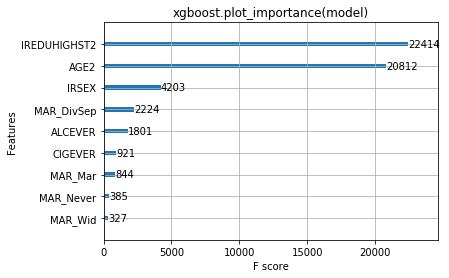

In [49]:
xgboost.plot_importance(modelXGB)
plt.title("xgboost.plot_importance(model)")
plt.show()

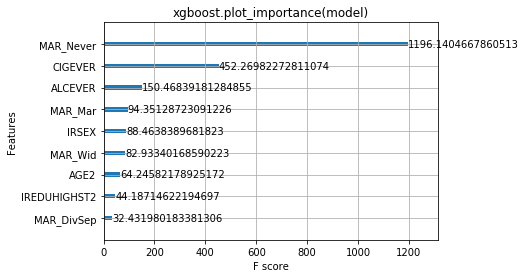

In [50]:
xgboost.plot_importance(modelXGB, importance_type="cover")
plt.title("xgboost.plot_importance(model)")
plt.show()

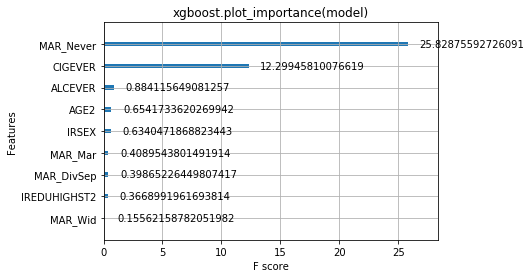

In [51]:
xgboost.plot_importance(modelXGB, importance_type="gain")
plt.title("xgboost.plot_importance(model)")
plt.show()

In [52]:
preds = modelLR.predict(valX)
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [53]:
predsXGB = modelXGB.predict(testX)
print(preds)
print(sum(preds))

[0 0 0 ... 0 0 0]
0


#### CK: You left off here, somehwat concerned that the XGB model is predicting all 0's. One potential solution would be to add a feature that's highly correlated with misuse (maybe one-hot one of the other pain killer features), that should be highly predictive of MISUSE, and then see if it improves. Specifically see if the calibration plots find groups of people with > 50% likelihood of misuse.

In [54]:
#Score LR
modelLR.score(valX, valY)

0.8423187022900763

In [55]:
#Score XGB
modelXGB.score(valX, valY)

0.836354961832061

In [60]:
predProbs = modelXGB.predict_proba(valX)[:,1]  #The [:,1] gives us just the probs, not the array
predProbs

array([0.14960751, 0.18866128, 0.18342794, ..., 0.31305236, 0.10786202,
       0.47694728], dtype=float32)

(array([8.130e+02, 1.075e+03, 6.550e+02, 3.210e+02, 3.340e+02, 1.160e+02,
        2.150e+02, 1.970e+02, 1.300e+02, 1.160e+02, 1.090e+02, 2.200e+01,
        1.300e+01, 4.300e+01, 2.000e+01, 5.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 5.000e+00]),
 array([0.060144  , 0.09855273, 0.13696148, 0.1753702 , 0.21377894,
        0.25218767, 0.29059643, 0.32900515, 0.36741388, 0.40582263,
        0.44423136, 0.4826401 , 0.52104884, 0.55945754, 0.5978663 ,
        0.63627505, 0.67468375, 0.7130925 , 0.75150126, 0.78990996,
        0.8283187 ], dtype=float32),
 <a list of 20 Patch objects>)

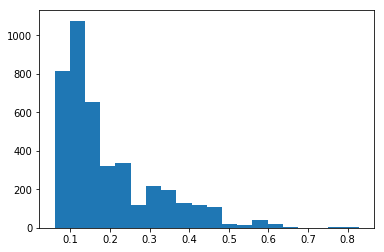

In [63]:
plt.hist(predProbs, bins=20)

In [61]:
#Run a few sample predictions (these are awful predictions right now ...)
print(modelLR.predict_proba(valX.iloc[6].to_numpy().reshape(1, -1))[0][1])
print(modelLR.predict_proba(valX.iloc[43].to_numpy().reshape(1, -1))[0][1])
print(modelLR.predict_proba(valX.iloc[123].to_numpy().reshape(1, -1))[0][1])

#Test with manual inputs
testInput = np.array([-1.7, 1, 1, -1.5, 1, 0, 0, 1, 0, 0])
print(modelLR.predict_proba(testInput.reshape(1, -1))[0][1])

0.020573592473810735
0.00875983056104805
0.006499612509675882
0.004723227819379848


## 5.2 Calibration

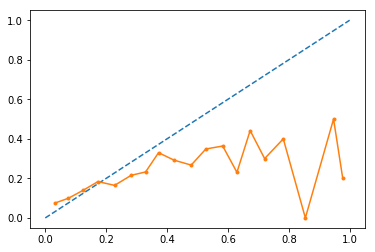

In [62]:
#Generate calibration curve data
prob_true, prob_pred = calibration_curve(y_true=valY, y_prob=predProbs, n_bins=20, normalize=True)

#Plot diag line
plt.plot([0, 1], [0, 1], linestyle='--')

#Plot calibration curves
plt.plot(prob_pred, prob_true, marker='.')
plt.show()

In [128]:
len(testY)

2516

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


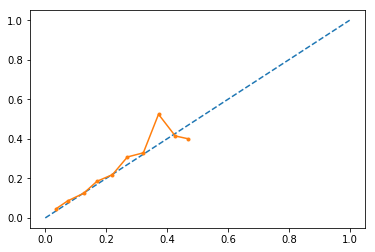

In [129]:
#Now we'll try to calibrate the model
calibrator = CalibratedClassifierCV(modelLR, cv='prefit')
calibrator.fit(valX, valY)

calProbs = calibrator.predict_proba(testX)[:,1]

fop, mpv = calibration_curve(testY, calProbs, n_bins=20) #Note this time we're not normalizing

#Plot diag line
plt.plot([0, 1], [0, 1], linestyle='--')

#Plot calibration curves
plt.plot(mpv, fop, marker='.')
plt.show()

(array([ 82., 200., 146., 195., 461., 379., 190.,  82., 131., 102., 104.,
        130.,  99.,  74.,  35.,  38.,  22.,  17.,  24.,   5.]),
 array([0.01059629, 0.03404905, 0.0575018 , 0.08095455, 0.10440731,
        0.12786006, 0.15131281, 0.17476557, 0.19821832, 0.22167108,
        0.24512383, 0.26857658, 0.29202934, 0.31548209, 0.33893484,
        0.3623876 , 0.38584035, 0.4092931 , 0.43274586, 0.45619861,
        0.47965136]),
 <a list of 20 Patch objects>)

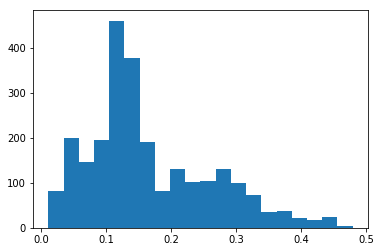

In [130]:
#Plot the distribution of probabiltiies
plt.hist(calProbs, bins=20)

In [131]:
#Finally, let's run individual predictions in our calibrated model
testInput = np.array([-1.7, 0, 0, -1.5, 0, 0, 0, 1, 0, 0])
'''Recall inputs are:
#AGE2	ALCEVER	CIGEVER	IREDUHIGHST2	IRSEX	MAR_DivSep	MAR_Mar	MAR_Never	MAR_U14	MAR_Wid
So here we're simulating a young, uneducated, drinker, smoker, male, never married ...
essentially the worst combination. Good that it gives us a high prediction as expected.
'''
print('UNCALIBRATED:', modelLR.predict_proba(testInput.reshape(1, -1))[0][1])
print('  CALIBRATED:', calibrator.predict_proba(testInput.reshape(1, -1))[0][1])

UNCALIBRATED: 0.04233046543505317
  CALIBRATED: 0.45142035250809764


## 5.3 Feature Explanation (Shapley Values)

In [132]:
type(calibrator)

sklearn.calibration.CalibratedClassifierCV

In [1]:
explainer = shap.LinearExplainer(modelLR, trainX, feature_dependence="independent")
#explainer = shap.LinearExplainer(modelLR, trainX)

'''Note shap.LinearExplainer does not accept a calibrated model.'''
shap_values = explainer.shap_values(testX)
#X_test_array = testX.toarray() # we need to pass a dense version for the plotting functions

NameError: name 'shap' is not defined

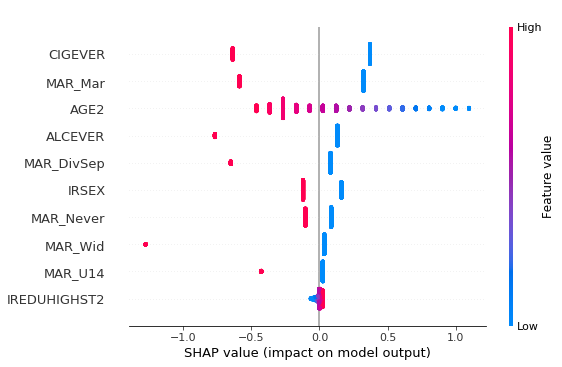

In [134]:
#Summary for the whole data set
shap.summary_plot(shap_values, testX)

In [135]:
ind = 1
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], testX.iloc[[ind]]    
)
shap.force_plot(
    0.16, shap_values[ind,:], testX.iloc[[ind]]    
)

In [136]:
#testX.iloc[[2]]
np.exp(explainer.expected_value)

0.008228329008295007

In [137]:
#Next, need to get this for an UNSEEN data point

In [138]:
print(shap_values.shape)
print(shap_values)

(2516, 10)
[[-0.26719493  0.13207321 -0.63524255 ...  0.08549457  0.02441066
   0.03488783]
 [ 0.31721229  0.13207321  0.37050817 ... -0.10320122  0.02441066
   0.03488783]
 [ 0.90161952  0.13207321 -0.63524255 ...  0.08549457 -0.42617878
   0.03488783]
 ...
 [-0.26719493  0.13207321  0.37050817 ...  0.08549457  0.02441066
   0.03488783]
 [-0.46199734 -0.76627468  0.37050817 ...  0.08549457  0.02441066
   0.03488783]
 [-0.26719493 -0.76627468 -0.63524255 ... -0.10320122  0.02441066
   0.03488783]]


### 5.3.1 Shapley Attempt #2

Try looking at this: https://github.com/slundberg/shap/blob/master/notebooks/kernel_explainer/Diabetes%20regression.ipynb

In [139]:
#explainer = shap.KernelExplainer(calibrator, trainX)
#explainer = shap.KernelExplainer(calibrator.predict_proba, trainX) #Probably would work but 14 hours

runThis = False #Takes a while to run, so don't want it running unless explicitly set
if runThis:
    trainXSummary = shap.kmeans(trainX, k=10) #Size of k directly impacts run time
    explainer = shap.KernelExplainer(calibrator.predict_proba, trainXSummary)
    shap_values = explainer.shap_values(testX)

In [140]:
runThis = False #Takes a while to run, so don't want it running unless explicitly set
if runThis:
    shap.summary_plot(shap_values, testX)

In [141]:
runThis = False #Takes a while to run, so don't want it running unless explicitly set
if runThis:

    ind = 0
    shap.force_plot(
        0.16, shap_values[1][ind,:], testX.iloc[[ind]]    #Need to figure out baseline
    )
    #Note on this one, shap_values[1] is the predicted class
    #and shap_values[0] is 1- the predicted class

### 5.3.2 Shapley Values on XGB Model

In [142]:
explainer = shap.TreeExplainer(modelXGB)
shap_values = explainer.shap_values(valX)

In [143]:
shap.force_plot(explainer.expected_value, shap_values[0,:], valX.iloc[0,:])

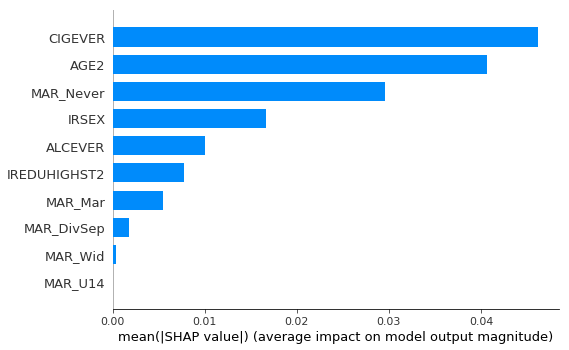

In [144]:
shap.summary_plot(shap_values, valX, plot_type="bar")

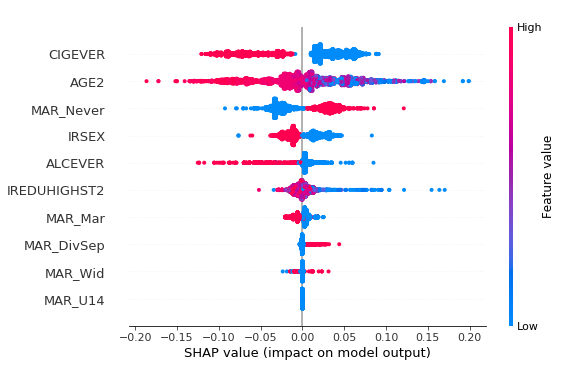

In [145]:
shap.summary_plot(shap_values, valX)

In [146]:
ind = 1
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], testX.iloc[[ind]]    
)

# 6. Save Models

In [107]:
#Save the model to pickle file
joblib.dump(modelLR, dataDir+'modelLR.mod')
joblib.dump(calibrator, dataDir+'calibLR.cal')

['./data/calibLR.cal']

# Ideas

* Remove columns that are "downstream" from MISUSE (e.g., have you ever misused oxycontin) and would therefore perfectly predict the dependent variable.
* Need to recode the variables, potentially one-hot encode those that need it ... need a good way to determine this
* We could look for class balance of < 90%, to eliminate the near-perfect predictors.
* Need to whittle down to a few variables that we can ask on a questionnaire
* Rather than a top-down approach, perhaps we use a bottom-up approach, and build a model that uses only a handful of variables, just so we can get something built end-to-end.  Once complete, or in parallel, we could then improve our features and continuously feed them into new versions of the model.

# Doodling

In [108]:
variable = 'HEALTH'
print(dfUsePainMeds.groupby([variable])[variable].count())

HEALTH
1     2977
2     6081
3     5072
4     2118
5      514
94       5
97       1
Name: HEALTH, dtype: int64


In [109]:
dfUsePainMeds

,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,CG30EST,CIG30AV,...,TOOLONG,TROUBUND,PDEN10,COUTYP4,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,MISUSE
19,2,4,4,991,9991,91,91,91,91,91,...,2,2,1,1,2,2,54.413648,40017,1,0
20,1,99,99,12,9999,99,1,30,99,4,...,2,2,2,2,2,2,3481.596088,40013,2,0
21,1,99,99,17,9999,99,4,93,93,93,...,2,2,2,2,2,2,1022.448042,40042,2,0
23,2,99,99,991,9991,91,91,91,91,91,...,2,2,1,1,2,2,628.886384,40016,2,0
33,2,99,99,991,9991,91,91,91,91,91,...,2,2,2,2,2,2,839.107735,40039,1,0
34,1,99,99,18,9999,99,2,93,93,93,...,2,2,2,2,2,2,1400.781545,40017,2,1
36,1,99,99,18,9999,99,4,93,93,93,...,1,1,2,3,2,2,1144.049469,40044,1,0
46,2,99,99,991,9991,91,91,91,91,91,...,2,2,2,2,2,2,3090.284207,40006,2,1
50,2,99,99,991,9991,91,91,91,91,91,...,2,2,2,2,2,2,4215.062783,40040,2,0
52,2,4,4,991,9991,91,91,91,91,91,...,2,2,1,1,2,2,4121.742730,40043,1,0
